### Libraries

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sqlalchemy import create_engine
from sklearn.metrics import pairwise_distances

**Database Connection**

In [4]:
db_username = 'postgres'
db_password = 'root'
db_host = 'localhost'
db_port = '5432'
db_name = 'week2'

connection_string = f'postgresql://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}'
engine = create_engine(connection_string)

data = pd.read_sql("SELECT * FROM xdr_data", engine)
data.head(2)

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0


### Step 2: Data Cleaning

In [5]:
# Check data types of the columns
print("Data Types:\n", data.dtypes)

# Convert relevant columns to numeric, forcing errors to NaN
columns_to_convert = [
    'TCP DL Retrans. Vol (Bytes)', 
    'TCP UL Retrans. Vol (Bytes)', 
    'Avg RTT DL (ms)', 
    'Avg RTT UL (ms)', 
    'Avg Bearer TP DL (kbps)', 
    'Avg Bearer TP UL (kbps)', 
    'Handset Type'
]

# Convert numeric columns
for col in columns_to_convert[:-1]:  # Exclude 'Handset Type' from numeric conversion
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Check for NaN values after conversion
print("NaN values after conversion:\n", data.isna().sum())

# Fill NaN values with mean for numeric columns and mode for 'Handset Type'
for col in columns_to_convert:
    if col == 'Handset Type':
        mode_value = data[col].mode()[0]
        data[col].fillna(mode_value, inplace=True)
    else:
        mean_value = data[col].mean()
        data[col].fillna(mean_value, inplace=True)


##Verify Data Types After Cleaning
print("Data types after cleaning:\n", data.dtypes)


Data Types:
 Bearer Id                                   float64
Start                                        object
Start ms                                    float64
End                                          object
End ms                                      float64
Dur. (ms)                                   float64
IMSI                                        float64
MSISDN/Number                               float64
IMEI                                        float64
Last Location Name                           object
Avg RTT DL (ms)                             float64
Avg RTT UL (ms)                             float64
Avg Bearer TP DL (kbps)                     float64
Avg Bearer TP UL (kbps)                     float64
TCP DL Retrans. Vol (Bytes)                 float64
TCP UL Retrans. Vol (Bytes)                 float64
DL TP < 50 Kbps (%)                         float64
50 Kbps < DL TP < 250 Kbps (%)              float64
250 Kbps < DL TP < 1 Mbps (%)               float64

C:\Users\desuk\AppData\Local\Temp\ipykernel_14956\142366342.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(mean_value, inplace=True)
C:\Users\desuk\AppData\Local\Temp\ipykernel_14956\142366342.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

### Step 3:Aggregate Data

In [6]:
user_experience = data.groupby('IMSI').agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Handset Type': lambda x: x.mode()[0],  # Most frequent handset
    'Avg Bearer TP DL (kbps)': 'mean'
}).reset_index()


### Step 4: Top, Bottom, and Most Frequent Values

In [7]:
top_tcp = user_experience.nlargest(10, 'TCP DL Retrans. Vol (Bytes)')
bottom_tcp = user_experience.nsmallest(10, 'TCP DL Retrans. Vol (Bytes)')
top_rtt = user_experience.nlargest(10, 'Avg RTT DL (ms)')
bottom_rtt = user_experience.nsmallest(10, 'Avg RTT DL (ms)')
top_throughput = user_experience.nlargest(10, 'Avg Bearer TP DL (kbps)')
bottom_throughput = user_experience.nsmallest(10, 'Avg Bearer TP DL (kbps)')

print("\nTop 10 TCP DL Retrans. Vol (Bytes):\n", top_tcp[['IMSI', 'TCP DL Retrans. Vol (Bytes)']])
print("\nBottom 10 TCP DL Retrans. Vol (Bytes):\n", bottom_tcp[['IMSI', 'TCP DL Retrans. Vol (Bytes)']])
print("\nTop 10 RTT DL (ms):\n", top_rtt[['IMSI', 'Avg RTT DL (ms)']])
print("\nBottom 10 RTT DL (ms):\n", bottom_rtt[['IMSI', 'Avg RTT DL (ms)']])
print("\nTop 10 Throughput (kbps):\n", top_throughput[['IMSI', 'Avg Bearer TP DL (kbps)']])
print("\nBottom 10 Throughput (kbps):\n", bottom_throughput[['IMSI', 'Avg Bearer TP DL (kbps)']])


Top 10 TCP DL Retrans. Vol (Bytes):
                IMSI  TCP DL Retrans. Vol (Bytes)
76093  2.082017e+14                 4.289488e+09
70098  2.082017e+14                 4.288060e+09
25608  2.082010e+14                 4.268432e+09
27762  2.082014e+14                 4.254644e+09
82401  2.082018e+14                 4.211189e+09
66329  2.082017e+14                 4.166591e+09
31005  2.082014e+14                 4.131046e+09
81324  2.082018e+14                 4.117753e+09
76790  2.082017e+14                 3.968072e+09
97867  2.082019e+14                 3.785295e+09

Bottom 10 TCP DL Retrans. Vol (Bytes):
                 IMSI  TCP DL Retrans. Vol (Bytes)
104971  2.082095e+14                          2.0
105042  2.082095e+14                          2.0
104956  2.082095e+14                          4.0
104967  2.082095e+14                          4.0
104993  2.082095e+14                          4.0
105016  2.082095e+14                          4.0
105022  2.082095e+14            

### Step 5: Distribution and Interpretation

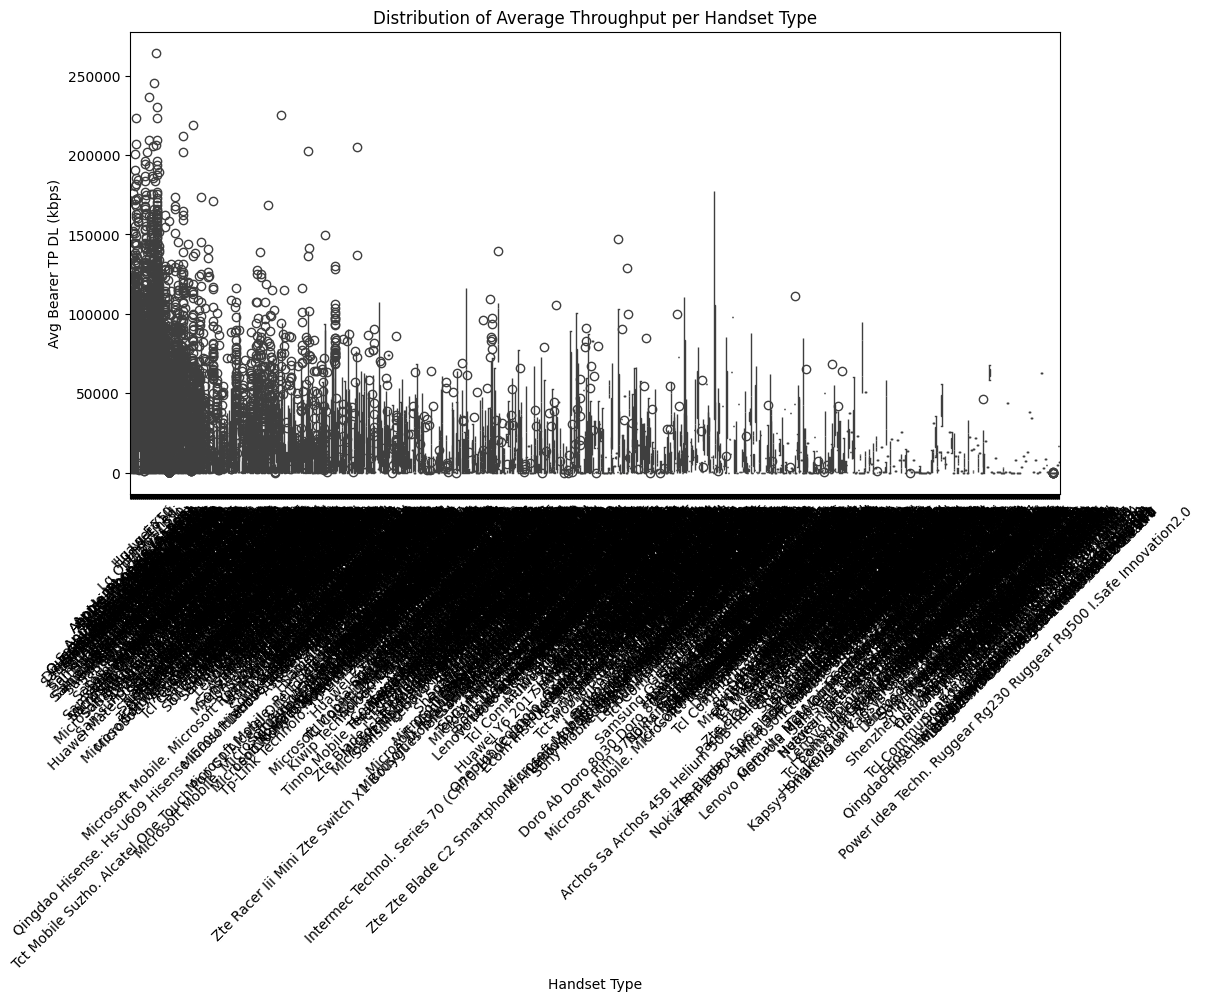

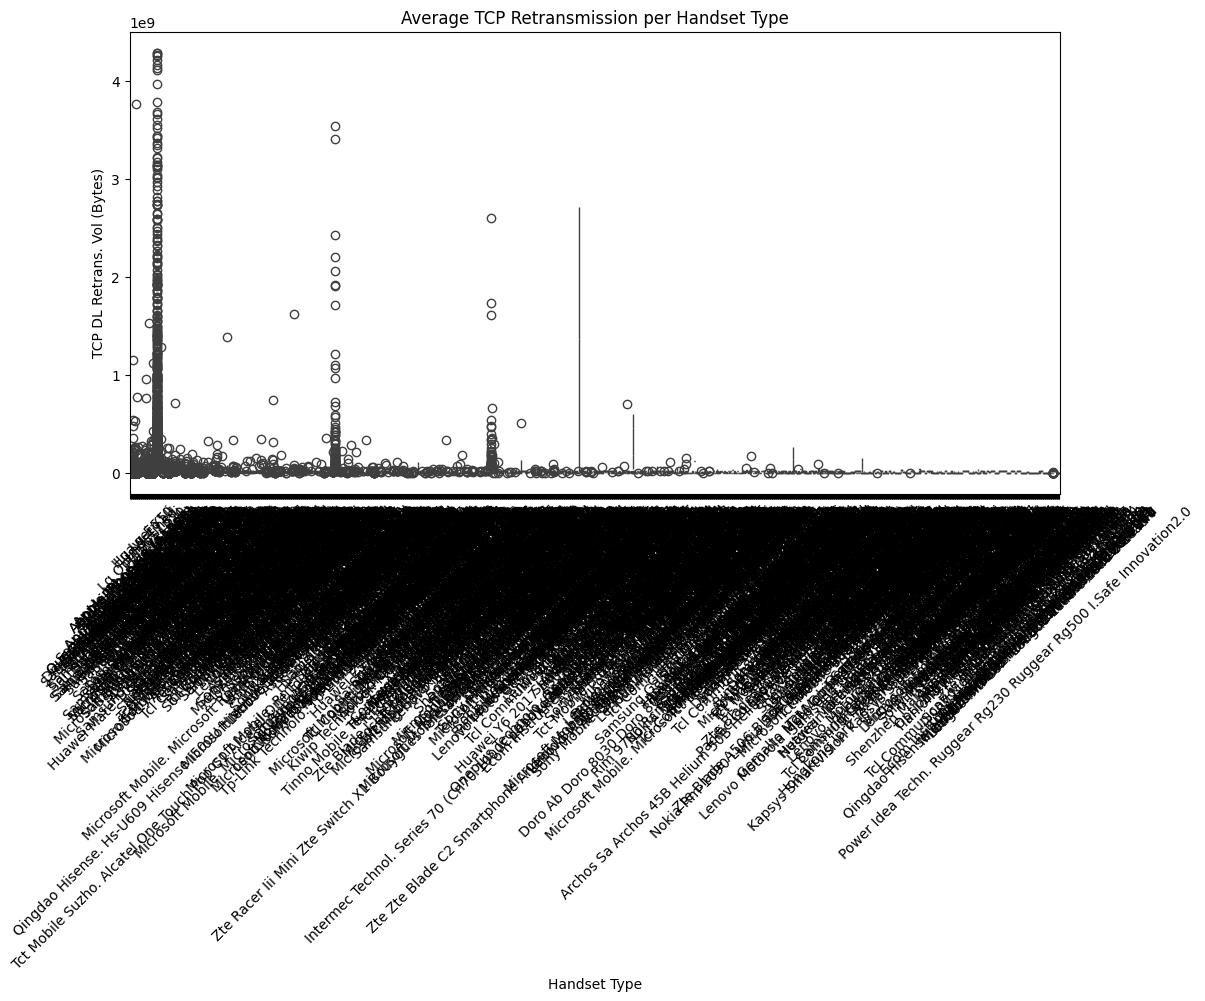

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=user_experience, x='Handset Type', y='Avg Bearer TP DL (kbps)')
plt.title('Distribution of Average Throughput per Handset Type')
plt.xticks(rotation=45)
plt.show()

# Interpretation: Analyze the boxplot for insights into throughput distribution.

plt.figure(figsize=(12, 6))
sns.boxplot(data=user_experience, x='Handset Type', y='TCP DL Retrans. Vol (Bytes)')
plt.title('Average TCP Retransmission per Handset Type')
plt.xticks(rotation=45)
plt.show()

### Step 6: K-Means Clustering

In [13]:
features = user_experience[['TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)']]

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=0)
user_experience['Cluster'] = kmeans.fit_predict(features)

# Describe each cluster
cluster_summary = user_experience.groupby('Cluster').mean(numeric_only=True)  # Ensure only numeric aggregation
print("Cluster Summary:\n", cluster_summary)

# Interpretation: Analyze the characteristics of each cluster based on the average metrics.

# Optional: Visualizing clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(data=user_experience, x='Avg Bearer TP DL (kbps)', y='TCP DL Retrans. Vol (Bytes)', hue='Cluster', palette='deep')
plt.title('K-Means Clustering of User Experience Metrics')
plt.xlabel('Average Throughput (kbps)')
plt.ylabel('Average TCP DL Retrans. Vol (Bytes)')
plt.legend(title='Cluster')
plt.show();

NameError: name 'KMeans' is not defined